# Lightly post-process data and save to a new folder
* All surveys (prefrosh, trait, spring well-being)
  * Remove responses with no participant id ('PID')
* Prefrosh and trait surveys
  * (These have individual-item responses, not just scales, and Qualtrics columns like "Finished" and "Response Date")
  * Remove responses with more than half of answers missing
  * Remove responses where P didn't complete the survey ('Finished' = 0)
  * Add several columns indicating how complete the survey was
  * Rename 'RecordedDate' to 'date' (datetime when the user completed the survey)
  * Remove other Qualtrics bookkeeping columns
* Output written to a new data folder, specified in the configuration below.

A good bit of data is dropped in post-processing, as demonstrated in this figure (the figure is generated at the end of this notebook):
![post_process_effects](plots/post_process_summary.png)

**Author: Everett Wetchler (everett.wetchler@gmail.com)**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Configuration-and-setup" data-toc-modified-id="Configuration-and-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Configuration and setup</a></span></li><li><span><a href="#Prefrosh-Data" data-toc-modified-id="Prefrosh-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prefrosh Data</a></span></li><li><span><a href="#Trait-Data" data-toc-modified-id="Trait-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Trait Data</a></span></li><li><span><a href="#Well-being-Data" data-toc-modified-id="Well-being-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Well-being Data</a></span></li><li><span><a href="#Show-dropped-record-counts-per-dataset" data-toc-modified-id="Show-dropped-record-counts-per-dataset-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Show dropped-record counts per dataset</a></span></li></ul></div>

<div style="background-color: rgba(164,0,0,1);height: 20px"></div><!-- Thick deep-red bar -->

## Configuration and setup

In [1]:
WRITE_POSTPROCESSED = True
DATA_INPUT_DIR = 'data/2018-2019/'
DATA_OUTPUT_DIR = 'data/postprocessed/'

In [2]:
####################################################
# Boilerplate import/setup code for general analysis
# everett.wetchler@gmail.com
####################################################

# Plot directly in notebook
# NOTE: break this command into it's own cell, and run
# it BEFORE everything below it. Unfortunately that's
# the only way to get the plot settings to stick.
%matplotlib inline

Everett Wetchler 2020-01-06 17:05:59 PST 

CPython 3.6.5
IPython 7.8.0

numpy 1.17.3
pandas 0.25.1
matplotlib 3.1.0
seaborn 0.9.0
watermark 2.0.1


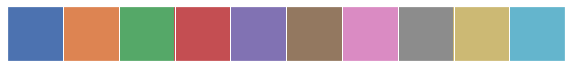

In [3]:
import datetime as dt
import os
import random
import simplejson as json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
sns.set()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

# Customize default chart graphics
mpl.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# It's useful to have some named colors handy
(SNS_BLUE, SNS_ORANGE, SNS_GREEN,
 SNS_RED, SNS_PURPLE, SNS_BROWN,
 SNS_PINK, SNS_GRAY, SNS_YELLOW,
 SNS_CYAN) = sns.color_palette()
sns.palplot(sns.color_palette())

# Watermark extension to print version/system information
# Flags:
# -a [author] --v (python/ipython versions) -d (date)
# -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version)
# -p [packages] (package info)
%load_ext watermark
%watermark -a 'Everett Wetchler' -v -d -t -z -w -p numpy,pandas,matplotlib,seaborn

####################################################
# END Boilerplate
####################################################

In [4]:
if not os.path.exists(DATA_OUTPUT_DIR):
    print("Making an empty directory for postproccessed data:", DATA_OUTPUT_DIR)
    os.mkdir(DATA_OUTPUT_DIR)

In [5]:
def load_basic_clean(filename):
    df = pd.read_csv(filename, index_col=0)
    print("%d rows x %d columns" % df.shape)
    
    dates = 0
    for c in df.columns:
        if c.lower().endswith('date'):
            dates += 1
            df[c] = pd.to_datetime(df[c])
    print(f"Converted {dates} columns to datetime")
    
    if 'PID' in df.columns:
        missing_pid = df['PID'].isnull()
        print(f"Dropping {missing_pid.sum()} surveys with no participant id (PID), {len(df)} remain")        
        df = df[-missing_pid]

    return df

In [6]:
DEMOGRAPHIC_COLS = [
    'Age',
    'Gender',
    'Race',
    'Major',
    'Rlgn',
    'FinclAid',
    'Born',
    'YearsUS',
    'CtznStatus',
    'Siblings',
    'FatherEd',
    'MotherEd',
    'FmlyIncome',
    'FmlyStatus',
]

def clean_qualtrics(df):
    q_cols = df.loc[:, 'UserLanguage':'PID'].iloc[:, 1:-1].columns
    N_QUESTIONS = len(q_cols)
    print(f"Found {N_QUESTIONS} survey question columns")
    demo_cols = [c for c in df.columns if c in DEMOGRAPHIC_COLS]
    print(f"...{len(demo_cols)} of which were demographic questions")
    score_cols = df.loc[:, 'DID':].iloc[:, 1:].columns
    print(f"Found {len(score_cols)} score columns")


    df['date'] = df['RecordedDate']

    unfinished = df['Finished'] != 1
    df = df[-unfinished]
    missing_too_many = df[q_cols].isnull().sum(axis=1) > (N_QUESTIONS / 2)
    df = df[-missing_too_many]
    print(f"Dropping {unfinished.sum()} unfinished surveys, "
          f"plus {missing_too_many.sum()} that skipped > half "
          f"of questions. {len(df)} remain")

    start_keeping = False
    keep_cols = []
    for c in df.columns:
        if c == 'PID':
            start_keeping = True
        if start_keeping or c in DEMOGRAPHIC_COLS:
            keep_cols.append(c)
    cols_to_drop = [c for c in df.columns if c not in keep_cols]
    df = df[keep_cols]
    print(f"Dropping {len(cols_to_drop)} Qualtrics and individual-question columns, {len(df.columns)} remain")
    
    return df

In [7]:
def dedup(df):
    # De-duplicate
    if 'date' in df.columns:
        df.sort_values('date')
    dedup = df.drop_duplicates(subset='PID')
    dedup.sort_index(inplace=True)
    dups = len(df) - len(dedup)
    if dups > 0:
        print(f"WARNING: {dups} duplicate participant ids (PID) found. Keeping only the latest entry for each PID")      
    else:
        print("No duplicate participant IDs -- all clear.")
    return dedup

In [8]:
def namestr(obj):
    namespace = globals()
    return [name for name in namespace if namespace[name] is obj][0]

In [9]:
def write(df):
    name = namestr(df)
    path = os.path.join(DATA_OUTPUT_DIR, f'{name}.csv')
    if WRITE_POSTPROCESSED:
        print(f"Saving '{name}' data to {path}")
        df.to_csv(path, index=False)
    else:
        print(f"(Not writing '{name}' dataframe yet - "
              f"set WRITE_POSTPROCESSED=True to change this)")

<div style="background-color: rgba(164,0,0,1);height: 20px"></div><!-- Thick deep-red bar -->

## Prefrosh Data

In [10]:
filepath_prefrosh = os.path.join(DATA_INPUT_DIR, 'Survey_Data/Prefrosh_Fall2018/prefrosh_cleaned.csv')
prefrosh = load_basic_clean(filepath_prefrosh)
prefrosh.head()

751 rows x 117 columns
Converted 3 columns to datetime
Dropping 0 surveys with no participant id (PID), 751 remain


,StartDate,EndDate,Status,Progress,Duration..in.seconds.,Finished,RecordedDate,ResponseId,ExternalReference,LocationLatitude,LocationLongitude,DistributionChannel,UserLanguage,Q16,Q1_1,Q1_2,Q1_3,Q1_4,Q1_5,Q1_6,Q1_7,Q1_8,Q2_1,Q2_2,Q2_3,Q2_4,Q2_5,Q2_6,Q2_7,Q2_8,Q2_9,Q2_10,Q2_11,Q2_12,Q2_13,Q3_1,Q3_2,Q3_3,Q3_4,Q3_5,Q3_6,Q3_7,Q3_8,Q3_9,Q3_10,Q4_1,Q4_2,Q4_3,Q4_4,Q4_5,Q4_6,Q4_7,Q4_8,Q4_9,Q4_10,Q4_11,Q4_12,Q5_1,Q5_2,Q5_3,Q5_4,Q5_5,Q5_6,Q5_7,Q5_8,Q5_9,Q5_10,Q5_11,Q5_12,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q7_1,Q7_2,Q7_3,Q7_4,Q9,Q10,Q11,Q12,Q13_1,Q13_2,Q13_3,Q13_4,Q13_5,Q14_1,Q14_2,Q14_3,Q14_4,Q14_5,Q14_6,PID,NID,DID,Extraversion,BAS,NTB,EC,PD,PT,Prosociality,Loneliness,Loneliness_R,PSS,PSS_R,Subj_Happiness,SWL,MalleableEmpathy,EMPATHY,POSITIVITY,NEGATIVITY,LIFE_SATISFACTION
1,2018-09-10 16:08:46,2018-09-10 16:09:02,0,100,15,1,2018-09-10 16:09:02,R_12FRzdn6szNEGwB,NaN,33.669495,-117.823105,anonymous,EN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ljl6BTIByo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-09-10 16:12:01,2018-09-10 16:12:13,0,100,11,1,2018-09-10 16:12:14,R_3R9lJ3eoFpYWlU1,NaN,37.417801,-122.171997,anonymous,EN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bkuKVEVOOp,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-09-10 16:05:57,2018-09-10 16:12:15,0,100,377,1,2018-09-10 16:12:15,R_23TZYEUq1bTok0t,NaN,29.555893,-98.365196,anonymous,EN,1,1.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,2.0,3.0,3.0,2.0,2.0,1.0,2.0,2.0,0.0,2.0,2.0,0.0,2.0,1.0,1.0,3.0,4.0,3.0,1.0,3.0,1.0,3.0,1.0,3.0,2.0,3.0,3.0,4.0,2.0,3.0,3.0,1.0,2.0,1.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,2.0,3.0,3.0,2.0,1.0,2.0,1.0,1.0,1.0,3.0,3.0,1.0,2.0,0.0,1.0,5.0,5.0,3.0,3.0,5.0,5.0,2.0,4.0,3.0,3.0,3.0,3.0,6.0,6.0,3.0,UPl0A7hyV0,NaN,NaN,1.000,1.769231,2.1,3.00,1.50,3.00,3.166667,1.750,2.250,1.00,3.00,4.00,3.8,4.000000,3.291667,1.384615,1.800,3.26250
4,2018-09-10 16:05:54,2018-09-10 16:12:19,0,100,385,1,2018-09-10 16:12:19,R_3e4AUGLe0jJ7397,NaN,41.874496,-87.650299,anonymous,EN,1,2.0,2.0,3.0,2.0,1.0,1.0,1.0,3.0,3.0,3.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,2.0,1.0,3.0,3.0,3.0,3.0,2.0,3.0,2.0,3.0,3.0,4.0,4.0,3.0,2.0,3.0,4.0,3.0,1.0,4.0,4.0,1.0,2.0,1.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,3.0,2.0,2.0,3.0,3.0,3.0,2.0,3.0,5.0,5.0,4.0,5.0,3.0,2.0,2.0,2.0,4.0,4.0,6.0,ra1xsp248Q,NaN,NaN,1.875,2.461538,3.0,3.75,1.25,2.75,3.833333,1.875,2.125,2.50,1.50,2.75,4.4,3.333333,3.416667,2.168269,2.125,2.69375
5,2018-09-10 16:06:07,2018-09-10 16:13:12,0,100,425,1,2018-09-10 16:13:12,R_1GIi7MYEAR4mDby,NaN,54.204407,37.611099,anonymous,EN,1,3.0,3.0,4.0,3.0,0.0,4.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0,2.0,2.0,3.0,3.0,3.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,3.0,3.0,4.0,1.0,2.0,1.0,4.0,3.0,4.0,3.0,4.0,1.0,4.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,4.0,2.0,2.0,4.0,4.0,4.0,4.0,3.0,4.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,5.0,4.0,5.0,6.0,5.0,5.0,4.0,6.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,IqidLJtjxg,11.0,11.0,2.875,2.461538,1.8,3.25,2.00,3.00,3.250000,1.000,3.000,0.25,3.75,5.00,5.2,2.000000,2.875000,2.668269,1.900,4.23750


In [11]:
not_18 = prefrosh['Q16'] != 1
print(f"Dropping {not_18.sum()} participants who were not 18 at the time of survey")
prefrosh = prefrosh[-not_18]
prefrosh = clean_qualtrics(prefrosh)
prefrosh = dedup(prefrosh)
print(prefrosh.shape)
write(prefrosh)
prefrosh.head()

Dropping 16 participants who were not 18 at the time of survey
Found 83 survey question columns
...0 of which were demographic questions
Found 18 score columns
Dropping 95 unfinished surveys, plus 2 that skipped > half of questions. 638 remain
Dropping 96 Qualtrics and individual-question columns, 22 remain
(636, 22)
Saving 'prefrosh' data to data/postprocessed/prefrosh.csv


,PID,NID,DID,Extraversion,BAS,NTB,EC,PD,PT,Prosociality,Loneliness,Loneliness_R,PSS,PSS_R,Subj_Happiness,SWL,MalleableEmpathy,EMPATHY,POSITIVITY,NEGATIVITY,LIFE_SATISFACTION,date
3,UPl0A7hyV0,NaN,NaN,1.000,1.769231,2.1,3.00,1.50,3.00,3.166667,1.750,2.250,1.00,3.00,4.00,3.8,4.000000,3.291667,1.384615,1.800,3.26250,2018-09-10 16:12:15
4,ra1xsp248Q,NaN,NaN,1.875,2.461538,3.0,3.75,1.25,2.75,3.833333,1.875,2.125,2.50,1.50,2.75,4.4,3.333333,3.416667,2.168269,2.125,2.69375,2018-09-10 16:12:19
5,IqidLJtjxg,11.0,11.0,2.875,2.461538,1.8,3.25,2.00,3.00,3.250000,1.000,3.000,0.25,3.75,5.00,5.2,2.000000,2.875000,2.668269,1.900,4.23750,2018-09-10 16:13:12
6,GR9ggA8Ajc,9.0,9.0,3.375,2.461538,2.4,2.25,1.00,1.75,2.750000,0.750,3.250,1.50,2.50,4.75,6.0,4.333333,2.770833,2.918269,1.700,4.12500,2018-09-10 16:13:52
7,vgxlTMkQs5,7.0,7.0,1.250,1.769231,3.4,3.00,1.25,3.00,2.833333,2.750,1.250,2.50,1.50,1.25,3.0,2.000000,2.708333,1.509615,2.325,1.75000,2018-09-10 16:14:14


<div style="background-color: rgba(164,0,0,1);height: 20px"></div><!-- Thick deep-red bar -->

## Trait Data

In [12]:
filepath_trait = os.path.join(DATA_INPUT_DIR, 'Survey_Data/Trait_Data_2018/Trait_data.csv')
for c in pd.read_csv(filepath_trait).columns:
    print(c)

StartDate
EndDate
Status
Progress
Duration (in seconds)
Finished
RecordedDate
ExternalReference
DistributionChannel
UserLanguage
Age
TIPI_1
TIPI_2
TIPI_3
TIPI_4
TIPI_5
TIPI_6
TIPI_7
TIPI_8
TIPI_9
TIPI_10
NPI_1
NPI_2
NPI_3
NPI_4
NPI_5
NPI_6
NPI_7
NPI_8
NPI_9
NPI_10
NPI_11
NPI_12
NPI_13
NPI_14
NPI_15
PosEmp_1
PosEmp_2
PosEmp_3
PosEmp_4
PosEmp_5
PosEmp_6
PosEmp_7
IRQ_1
IRQ_2
IRQ_3
IRQ_4
IRQ_5
IRQ_6
IRQ_7
IRQ_8
IRQ_9
IRQ_10
IRQ_11
IRQ_12
IRQ_13
IRQ_14
IRQ_15
IRQ_16
CESD_1
CESD_2
CESD_3
CESD_4
CESD_5
CESD_6
CESD_7
CESD_8
CESD_9
CESD_10
STAI_1
STAI_2
STAI_3
STAI_4
STAI_5
STAI_6
STAI_7
STAI_8
STAI_9
STAI_10
STAI_11
STAI_12
STAI_13
STAI_15
STAI_16
STAI_17
STAI_18
STAI_19
STAI_20
Text
SSS_Stnfrd
NTB_1
NTB_2
NTB_3
NTB_4
NTB_5
NTB_6
NTB_7
NTB_8
NTB_9
NTB_10
Prosociality_1
Prosociality_2
Prosociality_3
Prosociality_4
Prosociality_5
Prosociality_6
Prosociality_7
Prosociality_8
Prosociality_9
Prosociality_10
Prosociality_11
Prosociality_12
Loneliness_1
Loneliness_2
Loneliness_3
Loneliness_4
Loneline

In [13]:
trait = load_basic_clean(filepath_trait)
trait = clean_qualtrics(trait)
trait = dedup(trait)
write(trait)
trait.sample(5)

562 rows x 462 columns
Converted 2 columns to datetime
Dropping 0 surveys with no participant id (PID), 562 remain
Found 399 survey question columns
...14 of which were demographic questions
Found 51 score columns
Dropping 243 unfinished surveys, plus 4 that skipped > half of questions. 315 remain
Dropping 394 Qualtrics and individual-question columns, 69 remain
No duplicate participant IDs -- all clear.
Saving 'trait' data to data/postprocessed/trait.csv


,Age,Gender,Race,Major,Rlgn,FinclAid,Born,YearsUS,CtznStatus,Siblings,FatherEd,MotherEd,FmlyIncome,FmlyStatus,PID,NID,DID,Extraversion,Agreeableness,Openness,Conscientiousness,NPI,Positive_empathy,Pos_efficacy,Neg_efficacy,Pos_tendency,Neg_Tendency,CESD,STAI_Anxiety,Need_Belong,Prosociality,Loneliness,PSS,SubjHappiness,SWLS,Emp_theory,RS_1,RS_2,Self_Esteem,Self_monitor,Distress_Disclosure,Guidance,Warmth,Integration,Attachment,Nurturance,Reliable,Anticipated_Risks,Anticipated_Benefits,beq.nex,beq.pex,beq.str,PI,SI,CI,BFNE,BAS_drive,BAS_Fun_seeking,BAS_Fun_Reward_responsiveness,Suppression,Cogntive_Reappraisal,Extensic_improve,Extensic_worse,Intrinsic_imrpove,Intrinsic_worse,Empathic_Concern,Perspective_Taking,Personal_Distress,date
StartDate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-05 16:59:11,18,1.0,"Black or African American,South Asian,Other",CS,None,Yes,1.0,18.0,United States citizen,1.0,Master's Degree (MS),College Graduate (4 year),"$100,000 - $150,000",8.0,060uyicrNj,9,9,3.5,4.5,3.5,5.0,3.333333,3.714286,5.75,5.25,4.75,5.75,1.9,2.157895,3.3,2.666667,1.875,1.75,4.00,5.2,3.833333,4.000,4.250,2.2,10,3.071429,2.50,3.25,3.25,2.50,3.00,3.25,3.25,3.00,3.166667,4.75,4.666667,3.500000,4.0,3.625,3.571429,3.50,3.00,2.6,4.00,5.333333,3.833333,4.000000,3.500000,3.75,2.000000,2.428571,2.142857,2018-10-05 18:44:03
2018-10-05 15:13:47,21,1.0,Other,Symsys,None,No,1.0,21.0,United States citizen,1.0,Master's Degree (MS),College Graduate (4 year),"Over $150,000",9.0,uYFBAXpwcv,8,8,2.5,7.0,5.0,5.0,2.800000,3.571429,5.25,5.75,5.00,5.00,0.9,2.368421,4.5,2.666667,1.625,2.25,4.50,6.2,3.000000,4.000,3.750,2.2,15,3.500000,3.75,3.00,3.50,3.50,3.00,3.50,4.00,4.25,3.333333,5.50,3.666667,4.166667,4.0,2.750,4.142857,2.50,3.25,3.4,2.75,5.500000,4.000000,2.333333,3.166667,3.00,2.666667,2.571429,2.000000,2018-10-05 19:24:42
2018-10-07 16:44:31,20,1.0,East Asian,Computer Science,Other,No,1.0,20.0,United States citizen,1.0,Master's Degree (MS),Master's Degree (MS),"Over $150,000",9.0,zOtVt61Awh,15,18,2.5,4.5,3.5,6.0,3.000000,2.142857,4.75,5.50,6.25,5.75,1.8,2.684211,3.3,2.750000,2.000,2.50,4.25,5.2,6.000000,4.875,4.000,2.4,13,3.285714,2.50,3.00,2.75,2.25,2.50,3.00,4.00,4.75,2.500000,5.25,4.166667,4.666667,3.0,3.125,4.000000,2.75,3.00,3.4,7.00,5.500000,3.500000,3.000000,3.333333,4.00,1.666667,1.857143,1.714286,2018-10-11 16:33:42
2018-10-06 18:37:04,18,2.0,Black or African American,Public Policy,None,No,1.0,18.0,United States citizen,2.0,College Graduate (4 year),Master's Degree (MS),"Over $150,000",4.0,FtXDYm83Eu,10,10,2.0,5.0,6.0,3.5,2.733333,2.857143,5.00,6.25,6.25,4.50,1.6,2.526316,3.2,2.500000,2.000,3.25,2.00,3.8,2.166667,2.750,4.750,2.2,7,2.214286,4.00,3.75,3.50,3.25,3.50,4.00,2.50,4.75,5.000000,4.50,6.000000,4.166667,2.5,2.375,1.285714,2.50,2.25,3.8,2.25,4.500000,4.666667,1.333333,2.666667,2.25,2.833333,2.571429,2.142857,2018-10-06 20:43:28
2018-09-30 18:56:43,18,2.0,"East Asian,Black or African American",Mathematics,None,Yes,2.0,1.0,United States citizen,0.0,Master's Degree (MS),Master's Degree (MS),"$75,000 - $99,999",5.0,BumaiqbTaW,15,17,5.5,3.5,3.5,4.0,3.000000,3.428571,5.75,6.00,5.25,5.00,0.6,2.368421,3.8,2.750000,1.250,2.00,4.50,4.8,4.000000,3.000,4.125,2.2,16,2.500000,3.00,3.00,3.00,3.00,2.75,3.25,4.00,4.00,3.833333,5.00,4.833333,4.000000,3.5,3.000,2.857143,3.25,3.25,3.6,2.50,4.500000,3.833333,1.666667,3.500000,1.75,2.833333,2.285714,2.142857,2018-10-03 13:12:02


<div style="background-color: rgba(164,0,0,1);height: 20px"></div><!-- Thick deep-red bar -->

## Well-being Data

In [14]:
filepath_wellbeing_spring = os.path.join(DATA_INPUT_DIR, 'Survey_Data/Wellbeing_Spring_2019/Wellbeing_Spring_2019.csv')
wellbeing_spring = load_basic_clean(filepath_wellbeing_spring)
wellbeing_spring.head()

680 rows x 18 columns
Converted 0 columns to datetime
Dropping 27 surveys with no participant id (PID), 680 remain


,PID,dorm,Wellbeing_self_17,Lonely,Stressed,Satisfied,Rumination,Wellbeing_self_18,Social_Anxiety,Wellbeing_self_22,Anxiety_1,Anxiety_2,Wellbeing_self_19,Depression,Anhedonia,Wellbeing_self_21,Belonging,Wellbeing
3,6jHJKaD4Cb,Alondra,4.0,4.0,0.0,4.0,0.0,4.0,4.0,4.0,2.0,0.0,4.0,4.0,0.0,4.0,4.0,2.714286
4,vcM4I7ahKq,Alondra,2.0,1.0,2.0,2.0,3.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,2.0,1.0,1.0,1.357143
5,GRS7z5mppv,Alondra,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,3.785714
6,eaZChV6Zzv,Alondra,4.0,4.0,0.0,3.0,2.0,4.0,4.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,2.928571
7,95dslV1gqt,Alondra,4.0,1.0,1.0,1.0,3.0,2.0,4.0,2.0,2.0,3.0,1.0,2.0,4.0,1.0,1.0,2.214286


In [15]:
N_SCORES = len(wellbeing_spring.columns) - 2
print(N_SCORES, 'total score columns')
wellbeing_spring['scores_missing'] = wellbeing_spring.isnull().sum(axis=1)
wellbeing_spring['scores_missing'].value_counts().sort_index()

16 total score columns


0     546
1       2
10      1
16    104
Name: scores_missing, dtype: int64

In [16]:
wellbeing_spring[wellbeing_spring['scores_missing'] == N_SCORES].head()

,PID,dorm,Wellbeing_self_17,Lonely,Stressed,Satisfied,Rumination,Wellbeing_self_18,Social_Anxiety,Wellbeing_self_22,Anxiety_1,Anxiety_2,Wellbeing_self_19,Depression,Anhedonia,Wellbeing_self_21,Belonging,Wellbeing,scores_missing
36,eaZChV6Zzv,Alondra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
37,DVHOpKeyEt,Alondra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
38,yO9lkWPQCC,Alondra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
39,7WTyBtV0WF,Alondra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
40,jde0LtXmui,Alondra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16


In [17]:
n_blank = (wellbeing_spring['scores_missing'] == N_SCORES).sum()
print(f'Dropping {n_blank} empty records (plus 1 missing more than half of expected scores)')
wellbeing_spring = wellbeing_spring[wellbeing_spring['scores_missing'] == 0]
wellbeing_spring = dedup(wellbeing_spring)
write(wellbeing_spring)

Dropping 104 empty records (plus 1 missing more than half of expected scores)
Saving 'wellbeing_spring' data to data/postprocessed/wellbeing_spring.csv


<div style="background-color: rgba(164,0,0,1);height: 20px"></div><!-- Thick deep-red bar -->

## Show dropped-record counts per dataset

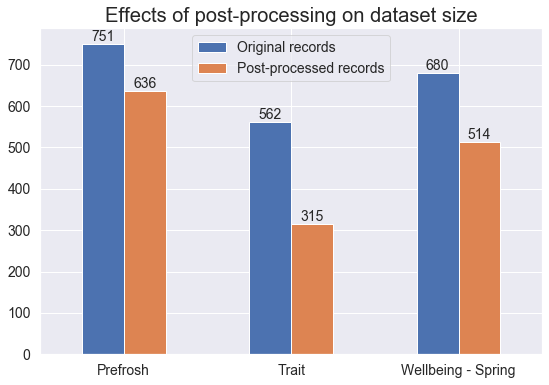

In [18]:
orig_prefrosh = len(pd.read_csv(filepath_prefrosh))
orig_trait = len(pd.read_csv(filepath_trait))
orig_wellbeing_spring = len(pd.read_csv(filepath_wellbeing_spring))
df = pd.DataFrame([
    ['Prefrosh', orig_prefrosh, len(prefrosh)],
    ['Trait', orig_trait, len(trait)],
    ['Wellbeing - Spring', orig_wellbeing_spring, len(wellbeing_spring)],
], columns=['Dataset', 'Original records', 'Post-processed records'])

fig, ax = plt.subplots(1)
df.plot(kind='bar', ax=ax)
ax.set_xticklabels(df['Dataset'], rotation=0)
ax.set_title("Effects of post-processing on dataset size")

# Label values on bars
for i, val in enumerate(df['Original records']):
    ax.text(i-0.125, val, val, horizontalalignment='center', verticalalignment='bottom')
for i, val in enumerate(df['Post-processed records']):
    ax.text(i+0.125, val, val, horizontalalignment='center', verticalalignment='bottom')

fig.savefig('plots/post_process_summary.png')